In [ ]:
!pip install importnb


In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import io
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# image_path = "/content/drive/MyDrive/Unet/ProcessedImages/images"
# mask_path = "/content/drive/MyDrive/Unet/ProcessedImages/masks"

In [ ]:
import shutil

drive_root = "/content/drive/MyDrive/Unet/ProcessedImages"

local_root = "/content/local_data"

if not os.path.exists(local_root):
    shutil.copytree(drive_root, local_root)
    print(f"Copied: {local_root}")
else:
    print("Data on Local.")

image_path = os.path.join(local_root, "images")
mask_path = os.path.join(local_root, "masks")

Copied: /content/local_data


Train, Test Split

In [ ]:
all_files = sorted(os.listdir(image_path))
train_files, val_test_files = train_test_split(
    all_files,
    test_size=0.3,
    random_state=42
)
val_files, test_files = train_test_split(
    val_test_files,
    test_size=0.33,
    random_state=42
)


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [ ]:
class LaneDataset(Dataset):
  def __init__(self, img_dir, mask_dir,file_list ,transform):
    super().__init__()
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)
  def __getitem__(self, idx):
    file_name = self.file_list[idx]
    img_path = os.path.join(self.img_dir, file_name)
    mask_file_name = file_name.replace('.jpg', '.png')
    mask_path = os.path.join(self.mask_dir, mask_file_name)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, 0)
    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask']
    mask = mask.float().unsqueeze(0)
    mask = mask /255
    mask = (mask > 0.5).float()
    return image, mask

In [ ]:
#train, test split
train_data = LaneDataset(image_path,mask_path,train_files,train_transform)
val_data = LaneDataset(image_path,mask_path,val_files,val_transform)
test_data = LaneDataset(image_path,mask_path,test_files,val_transform)
# Train, test loader
train_loader = DataLoader(train_data, batch_size = 16,num_workers=2 ,shuffle = True, drop_last=True)
val_loader = DataLoader(val_data, batch_size = 16,num_workers=2, shuffle = False, drop_last=True)
test_loader = DataLoader(test_data, batch_size = 16,num_workers=2, shuffle = False, drop_last=True)

UNET  

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channel, out_channel):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    x = self.conv(x)
    return x

In [ ]:
class Down(nn.Module):
  def __init__(self, in_channel, out_channel):
    super().__init__()
    self.down_conv = nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2),
        DoubleConv(in_channel, out_channel)
    )
  def forward(self,x):
    x = self.down_conv(x)
    return x
def skip_connection(x,y):
  if x.shape[2:] != y.shape[2:]:
    x = torch.nn.functional.interpolate(x, size=y.shape[2:], mode='bilinear', align_corners=True)
  out  = torch.cat([x,y], dim=1)
  return out
class Up(nn.Module):
  def __init__(self, in_channel, out_channel, x_skip_channel):
    super().__init__()
    self.up_conv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.dconv = DoubleConv(in_channel + x_skip_channel, out_channel)
  def forward(self,x,y):
    out = self.up_conv(x)
    out = skip_connection(out,y)
    out = self.dconv(out)
    return out

In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channel, out_channel):
    super().__init__()
    self.dconv1 = DoubleConv(in_channel, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128,256)
    self.down3 = Down(256,512)
    self.down4 = Down(512,1024)
    self.up1 = Up(1024,512,512)
    self.up2 = Up(512,256,256)
    self.up3 = Up(256,128,128)
    self.up4 = Up(128,64,64)
    self.out_conv = nn.Conv2d(64, out_channel, kernel_size=1)

  def forward(self,x):
    x1 = self.dconv1(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5,x4)
    x = self.up2(x,x3)
    x = self.up3(x,x2)
    x = self.up4(x,x1)
    x = self.out_conv(x)
    return x

Model

In [ ]:
class DiceLoss(nn.Module):
  def __init__(self, smooth=1e-6):
    super(DiceLoss, self).__init__()
    self.smooth = smooth
  def forward(self, y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
    return 1 - dice

In [ ]:
class LaneLoss(nn.Module):
    def __init__(self, weight=0.5, smooth=1e-6):

        super(LaneLoss, self).__init__()
        self.weight = weight
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        # Binary Cross Entropy
        bce_loss = self.bce(inputs, targets)
        # Dice
        inputs_prob = torch.sigmoid(inputs)

        inputs_flat = inputs_prob.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()

        dice_score = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        dice_loss = 1 - dice_score

        total_loss = (self.weight * bce_loss) + ((1 - self.weight) * dice_loss)

        return total_loss

In [ ]:
def calculate_iou(pred_logits, target_mask, threshold=0.5):
    pred_probs = torch.sigmoid(pred_logits)
    pred_binary = (pred_probs > threshold).float()

    intersection = (pred_binary * target_mask).sum()
    union = pred_binary.sum() + target_mask.sum() - intersection

    if union == 0:
        return 1.0

    return (intersection / union).item()

In [ ]:
model = Unet(in_channel=3,out_channel=1)
criterion = LaneLoss(weight = 0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [ ]:
def training_loop(epochs, optimizer, model, criterion ,scheduler ,train_loader, val_loader, test_loader, device):
  best_val_loss = float("inf")
  best_model_state = None
  model.to(device)
  criterion = criterion.to(device)
  for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}',leave=False)
    for images, masks in progress_bar:
      images = images.to(device)
      masks = masks.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      progress_bar.set_postfix({'loss': loss.item()})
    train_loss = running_loss / len(train_loader)
    # validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
      for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()
        val_iou += calculate_iou(outputs, masks)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, IOU: {avg_val_iou:.4f}")
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_model_state = model.state_dict()
  # Test
  model.load_state_dict(best_model_state)
  model.eval()
  test_loss = 0.0
  test_iou = 0.0
  with torch.no_grad():
    for images, masks in test_loader:
      images = images.to(device)
      masks = masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      test_loss += loss.item()
      test_iou += calculate_iou(outputs, masks)
  avg_test_loss = test_loss / len(test_loader)
  avg_test_iou = test_iou / len(test_loader)
  print(f"Test loss{avg_test_loss: .4f}, IOU: {avg_test_iou: .4f}")
  return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = training_loop(
    epochs=25,
    optimizer=optimizer,
    model=model,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device
)

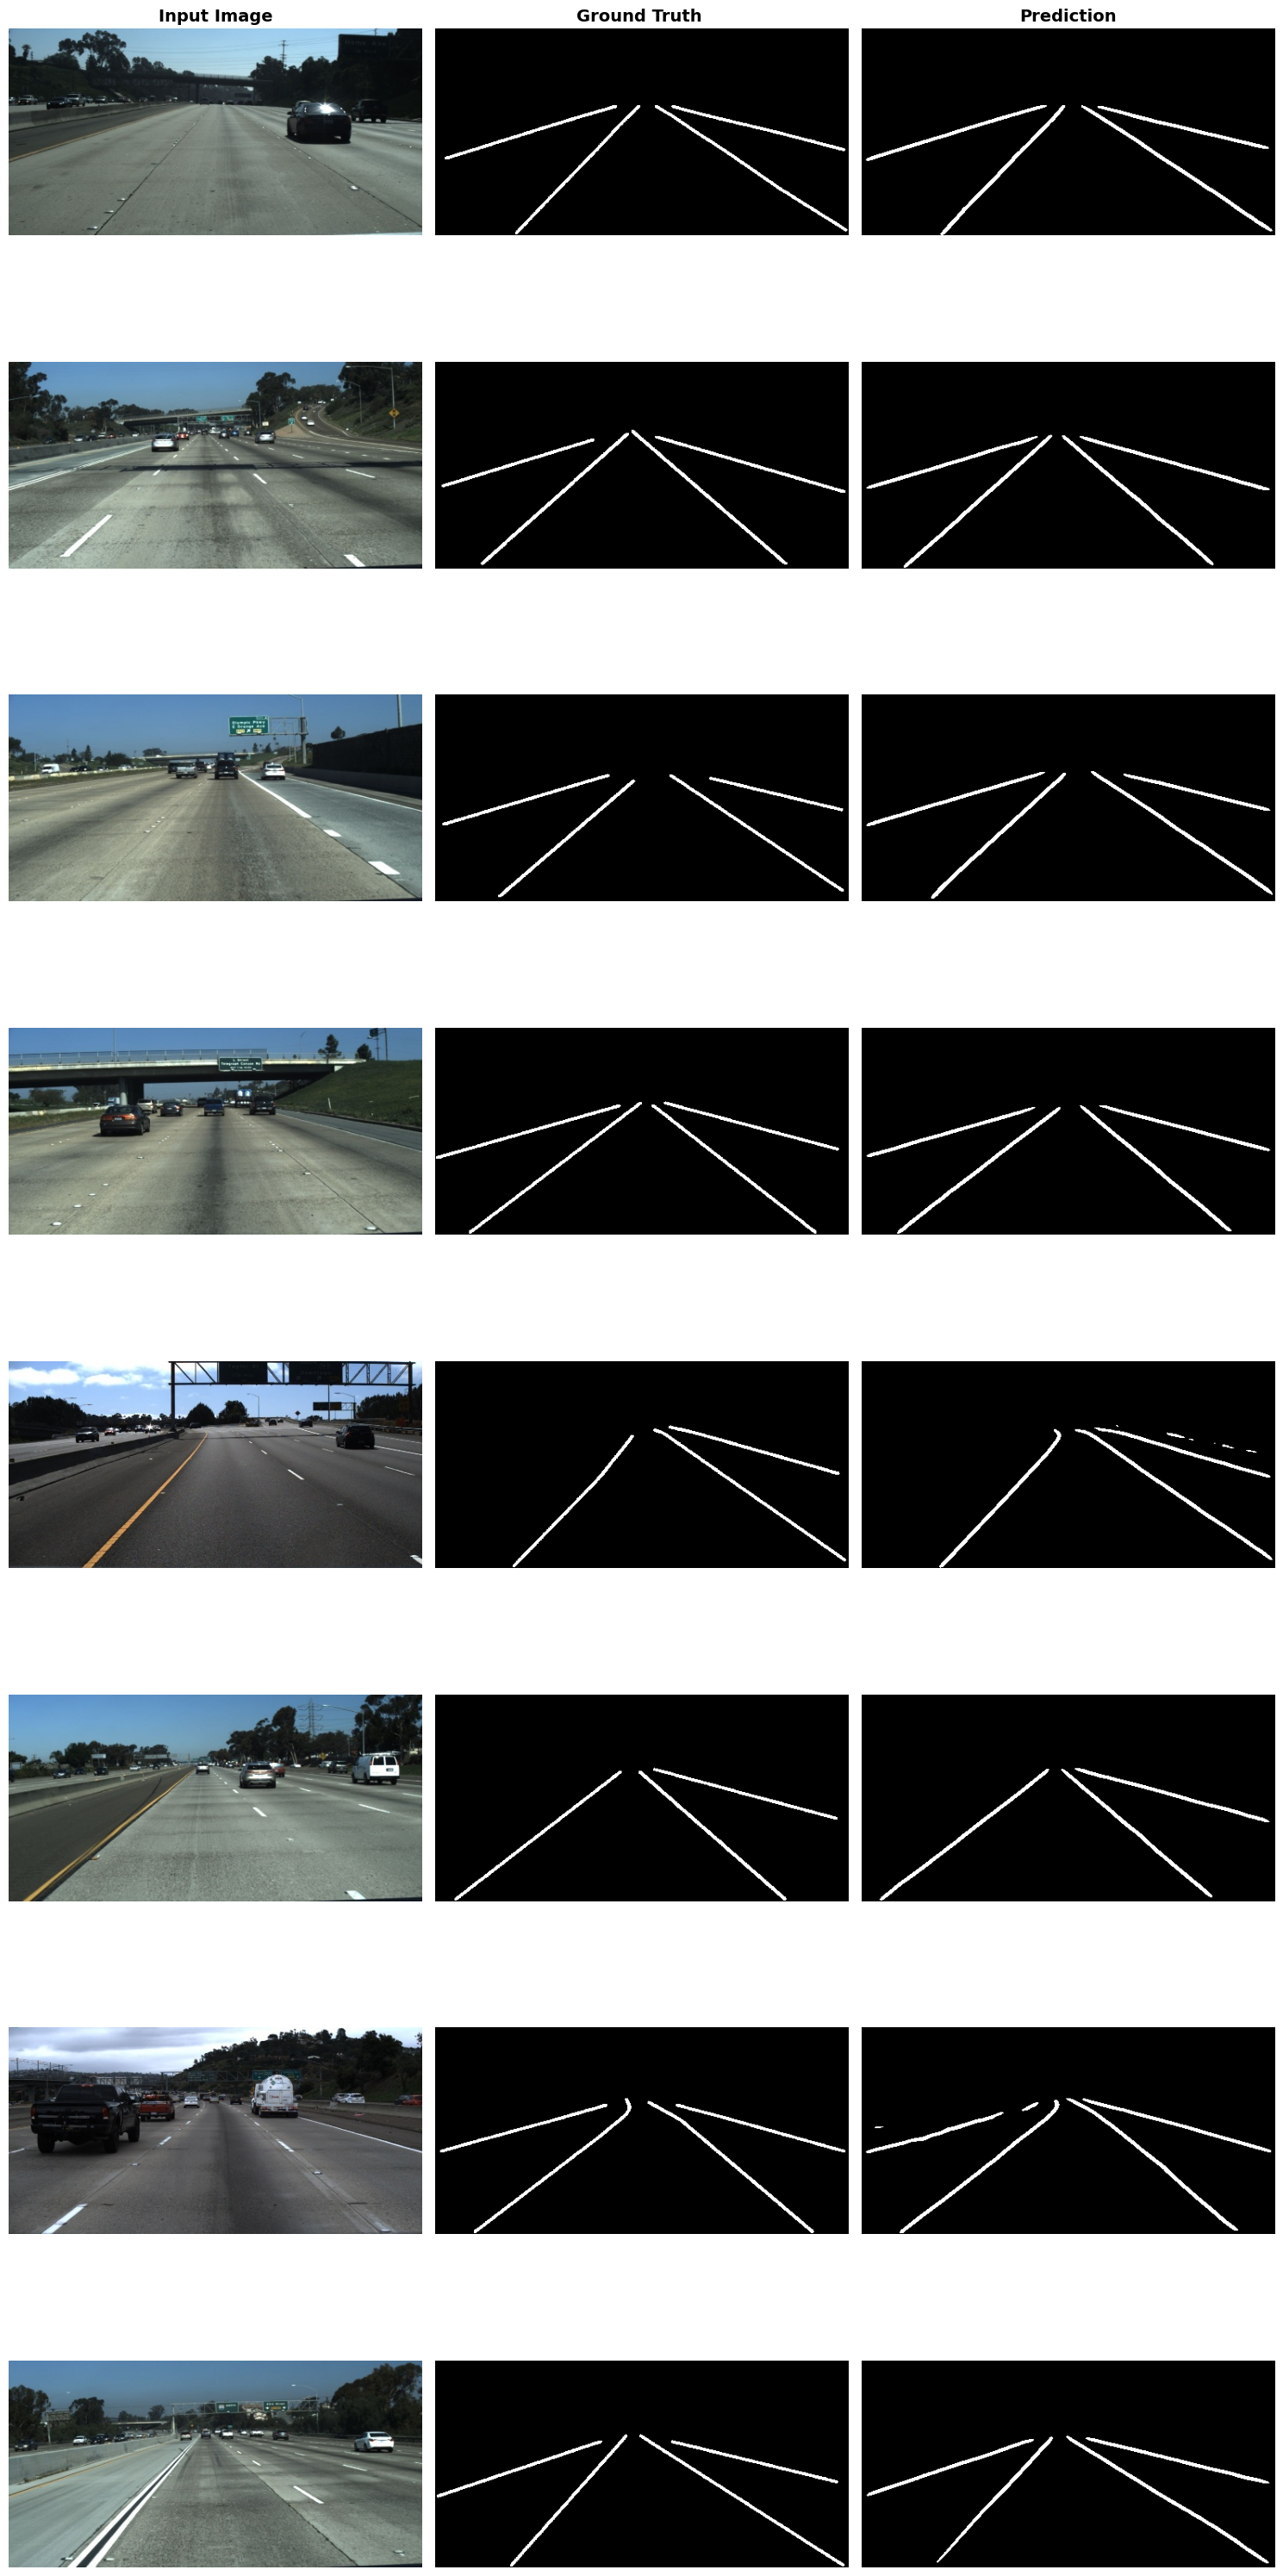

In [ ]:

def visualize_multiple_samples(model, loader, device, num_samples=5):

    model.eval()
    samples_shown = 0

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))


    cols = ["Input Image", "Ground Truth ", "Prediction"]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=14, fontweight='bold')

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            for i in range(images.shape[1]):
                if samples_shown >= num_samples:
                    break

                # (enormalize
                #  mean=0.5, std=0.5 -> Công thức ngược là: img * 0.5 + 0.5
                img_cpu = images[i].cpu().permute(1, 2, 0).numpy()
                img_cpu = img_cpu * 0.5 + 0.5
                img_cpu = np.clip(img_cpu, 0, 1)

                mask_true = masks[i].cpu().squeeze().numpy()

                mask_pred = preds[i].cpu().squeeze().numpy()

                axes[samples_shown, 0].imshow(img_cpu)
                axes[samples_shown, 0].axis('off')


                axes[samples_shown, 1].imshow(mask_true, cmap='gray')
                axes[samples_shown, 1].axis('off')

                axes[samples_shown, 2].imshow(mask_pred, cmap='gray')
                axes[samples_shown, 2].axis('off')

                samples_shown += 1

            if samples_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

visualize_multiple_samples(model, test_loader, device, num_samples=8)


In [ ]:
save_dir ="/content/drive/MyDrive/Unet"
model_name = 'unet_scratch_lane_seg.pth'
save_path = os.path.join(save_dir,model_name)
torch.save(model.state_dict(), save_path)
print(f" Saved: {save_path}")

 Saved: /content/drive/MyDrive/Unet/unet_scratch_lane_seg.pth
